In [ ]:
!conda install -y -c conda-forge bottleneck

In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import dscnn
from normalizing_flows.models.variational import parameterize, nll_loss, VariationalModel
from normalizing_flows.models.optimization import LinearWarmupSchedule
from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
from datasource import EraiRasDataLoader
from utils.pipeline_v2 import Pipeline, fillnan, clip, remove_monthly_means
from utils.distributions import normal
from tensorflow.keras.optimizers import Adamax
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
# regions
def southeast_us(dataset, scale_factor=1):
    lats, lons = dataset.lat, dataset.lon
    seus_lat_st = np.abs(lats - 25).argmin().values
    seus_lat_en = seus_lat_st + 15*scale_factor
    seus_lon_st = np.abs(lons - 260).argmin().values
    seus_lon_en = seus_lon_st + 30*scale_factor
    dataset_seus = dataset.isel(lat=slice(seus_lat_st, seus_lat_en),
                                lon=slice(seus_lon_st, seus_lon_en))
    return dataset_seus

erai_deg1_seus = southeast_us(erai_deg1)
ras_deg1_seus = southeast_us(ras_deg1)
ras_deg12_seus = southeast_us(ras_deg12, scale_factor=2)
ras_deg14_seus = southeast_us(ras_deg14, scale_factor=4)
ras_deg18_seus = southeast_us(ras_deg18, scale_factor=8)

In [4]:
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)
preprocess_maxt = Pipeline('MAXT', fillnan(0), clip(0), remove_monthly_means())
preprocess_hgt = Pipeline('HGT', fillnan(0), clip(0))
ras_seus_maxt_14 = preprocess_maxt(ras_deg14_seus)
ras_seus_maxt_1 = preprocess_maxt(ras_deg1_seus)
folds = list(split_fn(ras_seus_maxt_1, ras_seus_maxt_14))

In [5]:
def preprocess_vds(data_lo, data_hi, scale=2, n_epochs=1, batch_size=100, buffer_size=1000):
    data = tf.data.Dataset.zip((data_lo, data_hi)).shuffle(buffer_size)
    batch = data.batch(batch_size)
    return batch.repeat(n_epochs)

def preprocess_vae(data, scale=2, n_epochs=1, batch_size=100, buffer_size=1000):
    batch = data.shuffle(buffer_size).batch(batch_size)
    return batch.repeat(n_epochs)

In [ ]:
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 20
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, n_epochs=n_epochs, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, n_epochs=n_epochs, batch_size=sample_batch_size)
    vdsrcnn = dscnn.create_vdsrcnn(scale=wt_hi // wt, c_in=1, c_out=2, module_layers=2, n_layers=5, output_init='zeros')
    normal_fn = normal()
    #vdsrcnn = dscnn.create_bmg_cnn10(wt, ht, scale=wt_hi // wt, c_out=2)
    vdsrcnn = parameterize(vdsrcnn, normal_fn)
    vdsrcnn.compile(loss=nll_loss(normal_fn), optimizer=Adamax(lr=1.0E-3))
    vdsrcnn.fit(train_ds, epochs=n_epochs, steps_per_epoch=train_steps,
                validation_data=test_ds, validation_steps=test_steps)
    pred = vdsrcnn.predict_mean(test_lo_ds.batch(1))
    sample = vdsrcnn.sample(test_lo_ds.batch(1))
    plt.figure(figsize=(4*8,6))
    plt.subplot(1,4,1)
    plt.imshow(next(test_ds.__iter__())[0].numpy()[0].squeeze())
    plt.subplot(1,4,2)
    plt.imshow(next(test_ds.__iter__())[1].numpy()[0].squeeze())
    plt.subplot(1,4,3)
    plt.imshow(pred[0].numpy().squeeze())
    plt.subplot(1,4,4)
    plt.imshow(sample[0].numpy().squeeze())
    plt.show()

  0%|          | 0/12000 [00:00<?, ?it/s]

Fold 1/3
1200 training samples, 1200 test samples, 15x30 -> 60x120


100%|██████████| 12000/12000 [2:05:23<00:00,  1.60it/s, epoch=99, loss=0.994, nll=0.96, prior=0.962, test_nll=-, test_prior=-] 


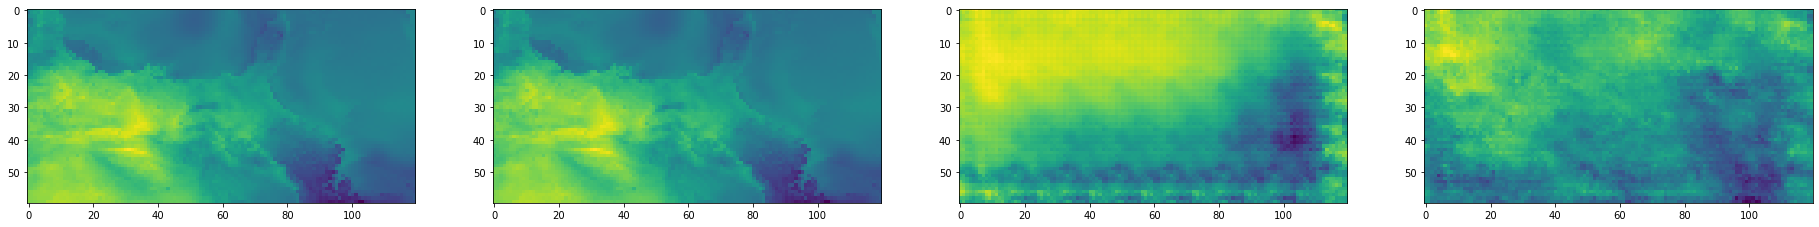

Fold 2/3
2400 training samples, 2400 test samples, 15x30 -> 60x120


  0%|          | 0/24000 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [11]:
def simple_inference_net(c_in, c_out, kernel_size=(3,3)):
    from tensorflow.keras import Model
    from tensorflow.keras.layers import Input, Conv2D
    from normalizing_flows.layers import ActNorm
    x = Input((None, None, c_in))
    y = Conv2D(c_out, kernel_size, padding='same', kernel_initializer='zeros')(x)
    y = ActNorm()(y)
    return Model(inputs=x, outputs=y)

sample_batch_size = 10
load_batch_size = 1200
n_epochs = 100
warmup_epochs = 10
models = []
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vae(train_hi_ds, n_epochs=n_epochs, batch_size=sample_batch_size)
    test_ds = preprocess_vae(test_hi_ds, n_epochs=n_epochs, batch_size=sample_batch_size)
    #vdscnn = dscnn.create_vdsrcnn(scale=wt_hi//wt, c_in=1, c_out=2, n_layers=5, module_layers=2, output_init='zeros')
    #vdscnn = dscnn.create_bmg_cnn10(wt, ht, scale=4, c_out=2)
    vdscnn = simple_inference_net(c_in=1, c_out=2)
    flow = GlowFlow(num_layers=4, depth=8, coupling_nn_ctor=coupling_nn_glow(hidden_dims=128))
    learning_rate = LinearWarmupSchedule(1.0E-3, num_warmup_steps=N_train//sample_batch_size*warmup_epochs)
    model = VariationalModel(vdscnn, normal(), transform=flow, optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate))
    model.train(train_ds, steps_per_epoch=N_train // sample_batch_size, num_epochs=n_epochs, supervised=False)
                #validation_data=test_ds, validation_steps=N_test // sample_batch_size)
    models.append(model)
    #pred = model.predict_mean(next(test_ds.__iter__()))
    #sample = model.sample(next(test_ds.__iter__()))
    pred = model.predict_mean()
    sample = model.sample()
    plt.figure(figsize=(4*8,6))
    plt.subplot(1,4,1)
    plt.imshow(next(test_ds.__iter__()).numpy()[0].squeeze())
    plt.subplot(1,4,2)
    plt.imshow(next(test_ds.__iter__()).numpy()[0].squeeze())
    plt.subplot(1,4,3)
    plt.imshow(pred[0].numpy().squeeze())
    plt.subplot(1,4,4)
    plt.imshow(sample[0].numpy().squeeze())
    plt.show()